In [1]:
file_path = "C:/data/youtube/"

In [2]:
from pydub.utils import get_array_type
import array
import numpy as np

def file_to_sound(sample):
    left = sample.split_to_mono()[0]
    bit_depth = left.sample_width*8
    array_type = get_array_type(bit_depth)
    numeric_array = array.array(array_type, left._data)
    sound = np.array(numeric_array)
    return sound

In [3]:
import librosa
import csv

def feature_extract_save(y,sr,save_file=None,label="Unknown"):
    data_directory = "C:/data/"
    # 한줄 생성
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr)
    to_append = [np.mean(spec_cent),np.mean(spec_bw),np.mean(rolloff),np.mean(zcr),np.mean(chroma_stft)]    
    for e in mfcc:
        to_append.append(np.mean(e))
    to_append.append(label)
    
    # 저장유무체크 
    if save_file == False or save_file == None:
        pass
    else:
        # header생성
        if save_file == True:
            save_file = data_directory +'feature.csv'
        header = ['spec_cent','spec_bw','rolloff','zcr','chroma_stft']
        for i in range(20):
            header.append(f'mfcc{i}')
        header.append('label')
        
        # 파일유무체크
        if not os.path.exists(save_file):
            with open(save_file,'w',newline='') as f:
                writer = csv.writer(f)
                writer.writerow(header)

        with open(save_file, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(to_append)
            
    return np.array(to_append[0:-1])

In [53]:
import pandas as pd
from keras import models,layers
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
import keras



# csv_data = 'C:/Users/user/desktop/sound_data/attendence/attend.csv'
def data_preprocessing(csv_data):
    data = pd.read_csv(csv_data,encoding='euc-kr')

    person_label = data[['label']]
    onehotencoder = OneHotEncoder()
    y = onehotencoder.fit_transform(person_label).toarray()
    
    # normalizing
    scaler = StandardScaler()
    X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float))
    return X,y,onehotencoder,scaler

def one_hot_decoder(oh_encoder,y):
    return oh_encoder.categories_[0][np.argmax(y,axis=1)].reshape(-1,1)

# spliting of dataset into train and test dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

def model_making(input_shape,output_len):
    # creating a model
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(input_shape[1:]) ))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dense(output_len, activation='softmax'))

    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    
    return model

def model_making2(input_shape,output_len):
    # creating a model
    model = models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(input_shape[1:]) ))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(output_len, activation='softmax'))

    
    model.compile(optimizer='adam',
          loss='categorical_crossentropy',
          metrics=['accuracy'])
    
    return model

def ML_model_making(X,y):
    MLmodel = GradientBoostingClassifier()
    MLmodel.fit(X,y)
    return MLmodel

def model_fitting(model,X,y):
    
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    
#     history = model.fit(X, y, epochs=30, batch_size=128)
    history = model.fit(X_train, y_train,validation_split=0.1, epochs=100, batch_size=2**15)
    
    test_loss, test_acc = model.evaluate(X_test,y_test)
    print('test_acc: ',test_acc)
    return model,history
    
def model_predict(model,X):

    # predictions
    predictions = model.predict(X)

    return predictions

In [5]:
def MLmodel():
#     csv_data = 'C:/Users/user/desktop/sound_data/attendence/attend.csv'
    X,y,oh_encoder,scaler = data_preprocessing(csv_data)
    y = one_hot_decoder(oh_encoder,y)
    return ML_model_making(X,y)

In [5]:
import os
from pydub import AudioSegment
from tqdm import tqdm
import matplotlib.pyplot as plt

## 파일 읽어오기

In [60]:
tqdm._instances.clear()

In [37]:
mp3_file_path_list = []
for i in os.listdir(file_path):
    i = file_path+i
    for j in os.listdir(i):
        mp3_file_path_list.append(os.path.join(file_path,i,j))

In [6]:
for file in os.listdir(file_path):
    for j in os.listdir(file_path + file):
        data = AudioSegment.from_file(os.path.join(file_path,file,j))
        sound = file_to_sound(data)
        sound = (sound/(2**15-1))
        for i in tqdm(range(0,len(sound),512),desc=j,leave=False):
            feature_extract_save(sound[i:i+511],44100,save_file=False,label = file)

cho.mp3:   0%|                                                                               | 0/71643 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


In [ ]:
sample = AudioSegment.from_file("C:/data/hello.wav")
sound = file_to_sound(sample)
sound = (sound/(2**15-1))
for i in tqdm(range(0,len(sound),512)):
    feature_extract_save(sound[i:i+511],sr=44100)

plt.specgram(sound[20000:44100],NFFT=512, Fs=44100)
plt.show()

In [276]:
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

In [279]:
df = pd.read_csv('C:/data/feature.csv')

In [333]:
std = StandardScaler()
df_std = std.fit_transform(df.values[:,:-1])

pca = PCA()
df_pca = pca.fit_transform(df_std)

In [341]:
pca.explained_variance_ratio_.cumsum()

array([0.23524362, 0.31721391, 0.39104352, 0.45964048, 0.51445992,
       0.56729085, 0.61420566, 0.65990381, 0.70193878, 0.7417299 ,
       0.77583576, 0.80879663, 0.84019555, 0.86742985, 0.8931748 ,
       0.91544368, 0.93629839, 0.95582272, 0.96944388, 0.98106873,
       0.99031486, 0.99609601, 0.99865079, 0.99965571, 1.        ])

In [ ]:
for i in range(25):
    plt.scatter(df['label'],df.values[:,i],marker='x')
    plt.show()

In [ ]:
for file in os.listdir(file_path):
    for j in os.listdir(file_path + file):
        data = AudioSegment.from_file(os.path.join(file_path,file,j))
        sound = file_to_sound(data)
        for i in range(5):
            plt.specgram(sound[i*44100:(i+1)*44100], Fs=44100)
            plt.show()

In [ ]:
csv_data = 'C:/data/feature.csv'
X,y,oh_encoder = data_preprocessing(csv_data)
a = one_hot_decoder(oh_encoder,y)
score = []
for i in tqdm(range(1)):
    X_train,X_test,y_train,y_test=train_test_split(X,a[:,0])
    print(1)
    MLmodel = ML_model_making(X_train,y_train)
    print(2)
    score.append(MLmodel.score(X_test,y_test))
np.mean(score)

In [54]:
csv_data = 'C:/data/feature_final.csv'
X,y,oh_encoder,std = data_preprocessing(csv_data)
model = model_making(X.shape,y.shape[1])
model,history = model_fitting(model,X,y)

Train on 289394 samples, validate on 32155 samples
Epoch 1/100
289394/289394 [==============================] - ETA: 2s - loss: 1.4317 - acc: 0.211 - ETA: 0s - loss: 1.3686 - acc: 0.326 - ETA: 0s - loss: 1.3154 - acc: 0.417 - ETA: 0s - loss: 1.2663 - acc: 0.477 - 1s 2us/step - loss: 1.2212 - acc: 0.5179 - val_loss: 0.9767 - val_acc: 0.6951
Epoch 2/100
289394/289394 [==============================] - ETA: 0s - loss: 0.9786 - acc: 0.694 - ETA: 0s - loss: 0.9328 - acc: 0.707 - ETA: 0s - loss: 0.8896 - acc: 0.714 - ETA: 0s - loss: 0.8497 - acc: 0.723 - 0s 1us/step - loss: 0.8156 - acc: 0.7323 - val_loss: 0.6421 - val_acc: 0.7779
Epoch 3/100
289394/289394 [==============================] - ETA: 0s - loss: 0.6410 - acc: 0.780 - ETA: 0s - loss: 0.6154 - acc: 0.787 - ETA: 0s - loss: 0.5947 - acc: 0.793 - ETA: 0s - loss: 0.5773 - acc: 0.798 - 0s 1us/step - loss: 0.5630 - acc: 0.8020 - val_loss: 0.4943 - val_acc: 0.8185
Epoch 4/100
289394/289394 [==============================] - ETA: 0s - loss:

In [19]:
## mixed file
# for file in os.listdir(file_path):
#     for j in os.listdir(file_path + file):
#         data = AudioSegment.from_file(os.path.join(file_path,file,j))
#         sound = file_to_sound(data)
#         sound = (sound/(2**15-1))
#         for i in tqdm(range(0,len(sound),512)):
#             feature_extract_save(sound[i:i+511],44100,save_file=False,label = file)
mp3_file_path_list = []
for i in os.listdir(file_path):
    i = file_path+i
    for j in os.listdir(i):
        mp3_file_path_list.append(os.path.join(file_path,i,j))
        
data = []        
for i in mp3_file_path_list:
    data.append(AudioSegment.from_file(i))


In [13]:
mp3_file_path_list

['C:/data/youtube/cho\\cho.mp3',
 'C:/data/youtube/cho\\cho2.mp3',
 'C:/data/youtube/joe\\joe.mp3',
 'C:/data/youtube/joe\\joe2.mp3',
 'C:/data/youtube/joe\\joe3.mp3',
 'C:/data/youtube/kim\\kim.mp3',
 'C:/data/youtube/sul\\sul.mp3',
 'C:/data/youtube/sul\\sul2.mp3']

In [32]:
for i in data:
    print(i.duration_seconds)

831.7659637188209
449.09714285714284
263.05886621315193
639.9187301587301
316.13968253968255
1221.121065759637
599.2141496598639
657.2408163265306


In [79]:
data_mixed = data[0][10000:12000]+data[2][13000:14000]+data[5][14000:19000]+data[6][10000:12000]
data_mixed2 = data[1][3000:4000]
# data_mixed = data[0][10000:50000]

In [80]:
data_mixed

In [81]:
def predict_to_file(model,feature,std):
    save_file = 'C:/data/feature_predict.csv'
    feature = std.transform(feature[np.newaxis,:])
    to_append = model.predict(feature)
#     temp_10 = []
#     temp_10.append(to_append)
#     np.bincount(to_append)
    to_append = to_append[0]
    # header생성
    header = ['cho','joe','kim','sul']

    # 파일유무체크
    if not os.path.exists(save_file):
        with open(save_file,'w',newline='') as f:
            writer = csv.writer(f)
            writer.writerow(header)

    with open(save_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(to_append)

In [82]:
mixed_sound = file_to_sound(data_mixed)
mixed_sound = mixed_sound/(2**15-1)
for i in (range(0,len(mixed_sound),512)):
    feature = feature_extract_save(mixed_sound[i:i+511],44100,save_file=False)
    predict_to_file(model,feature,std)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tunin

In [109]:
512/44100

0.011609977324263039

In [ ]:
10개씩 읽어서 제일 많은사람 목소리
2,1,5,2초 씩 말했음

In [83]:
df = pd.read_csv('C:/data/feature_predict.csv')
y = df
print(np.bincount(np.argmax(np.array(y),axis=1)))


count = 10
decoded_value = np.argmax(np.array(y),axis=1)
temp_voice = []
voice = []
for i in decoded_value:
    temp_voice.append(i)
    if count == 1:
        temp_voice = np.array(temp_voice)
        print(temp_voice,end=' ')
        temp = np.argmax(np.bincount(temp_voice))
        voice.append(temp)
        count=10
        temp_voice = []
    count = count-1
voice = np.array(voice)
        


In [107]:
voice

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3], dtype=int64)

In [95]:
np.argmax(np.bincount(temp_voice))

3

In [111]:
data_test = AudioSegment.from_file('C:/data/youbube_test/joe_test.mp3')

In [114]:
data_test[1000:20000]
mixed_sound = file_to_sound(data_test)
mixed_sound = mixed_sound/(2**15-1)
for i in (range(0,len(mixed_sound),512)):
    feature = feature_extract_save(mixed_sound[i:i+511],44100,save_file=False)
    predict_to_file(model,feature,std)

C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')
C:\ProgramData\Anaconda3\lib\site-packages\librosa\core\pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tunin

In [116]:
df = pd.read_csv('C:/data/feature_predict.csv')
y = df
print(np.bincount(np.argmax(np.array(y),axis=1)))


count = 10
decoded_value = np.argmax(np.array(y),axis=1)
temp_voice = []
voice = []
for i in decoded_value:
    temp_voice.append(i)
    if count == 1:
        temp_voice = np.array(temp_voice)
        temp = np.argmax(np.bincount(temp_voice))
        voice.append(temp)
        count=10
        temp_voice = []
    count = count-1
voice = np.array(voice)

[  240 13028   203   559]


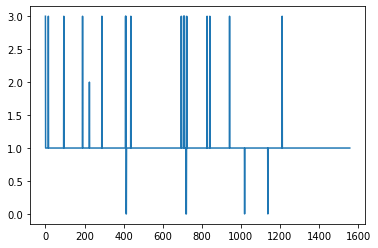

In [118]:
plt.plot(voice)

In [40]:
a = model.predict(feature[np.newaxis,:])

In [41]:
a

array([[0., 0., 1., 0.]], dtype=float32)

In [42]:
len(mixed_sound)

1764000

In [43]:
mixed_sound

array([-0.02166814, -0.02056948, -0.01910459, ..., -0.03942991,
       -0.03781243, -0.03622547])

In [44]:
df = pd.read_csv(csv_data)

In [45]:
df[df['label']=='cho'].iloc[:,:-1]

,spec_cent,spec_bw,rolloff,zcr,chroma_stft,mfcc0,mfcc1,mfcc2,mfcc3,mfcc4,...,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19
0,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.37080,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.37080,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.37080,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.37080,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,-1131.37080,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110320,2986.941523,4457.272967,7622.753906,0.005859,0.595496,-363.43045,126.497380,-1.570504,31.510284,3.435196,...,1.588545,8.833174,6.165791,-4.537354,1.451564,-6.841421,2.833741,-3.303915,6.486066,0.920157
110321,3045.517198,4285.030369,7838.085938,0.025391,0.653260,-341.87833,143.538420,-3.165713,32.583626,-7.847923,...,-1.447948,3.645006,-8.529385,-1.424799,-10.788826,-5.494023,-1.000538,-13.718868,4.701401,-7.324825
110322,5290.117063,4818.979331,11498.730469,0.067871,0.519262,-585.73110,81.769820,-35.590813,19.231926,-18.086952,...,8.297338,17.099663,-1.525354,3.793507,-5.115258,-6.232979,0.510477,-6.204635,4.191120,-12.217742
110323,6722.126375,5747.352520,13522.851562,0.023926,0.584323,-843.69670,49.644882,18.020302,48.241104,16.210873,...,-19.270317,-3.959885,-5.226895,-7.265166,4.925113,-6.326796,-6.598226,9.937302,9.703129,3.124310


In [114]:
df[df['label']=='cho'].iloc[:,:-1].values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

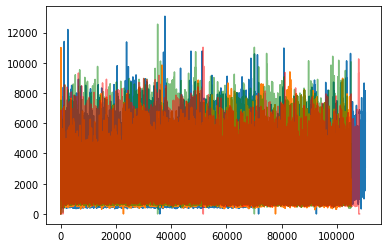

In [46]:
i=0
plt.plot(df[df['label']=='cho'].iloc[:,:-1].values[:,i])
plt.plot(df[df['label']=='joe'].iloc[:,:-1].values[:,i])
plt.plot(df[df['label']=='kim'].iloc[:,:-1].values[:,i],color='g',alpha=0.5)
plt.plot(df[df['label']=='sul'].iloc[:,:-1].values[:,i],color='r',alpha=0.5)
plt.show()

In [50]:
df[df['label']=='cho'].shape,\
df[df['label']=='joe'].shape,\
df[df['label']=='kim'].shape,\
df[df['label']=='sul'].shape

((110325, 26), (105006, 26), (105179, 26), (108222, 26))